# Git Repository Bringup

In [104]:
!git version

git version 2.34.1
time: 107 ms (started: 2023-09-26 10:13:29 +00:00)


In [105]:
!git clone https://github.com/ramwtz/data-science-project.git

fatal: destination path 'data-science-project' already exists and is not an empty directory.
time: 107 ms (started: 2023-09-26 10:13:30 +00:00)


In [106]:
!ls

data-science-project  drive  sample_data
time: 105 ms (started: 2023-09-26 10:13:30 +00:00)


In [107]:
%cd data-science-project/

/content/data-science-project
time: 2.56 ms (started: 2023-09-26 10:13:30 +00:00)


In [108]:
!pwd

/content/data-science-project
time: 105 ms (started: 2023-09-26 10:13:30 +00:00)


In [109]:
!git switch dev/ram

Already on 'dev/ram'
Your branch is up to date with 'origin/dev/ram'.
time: 105 ms (started: 2023-09-26 10:13:30 +00:00)


In [110]:
%cd ..

/content
time: 2.03 ms (started: 2023-09-26 10:13:30 +00:00)


# Basic Bringup for Remote Envrionment

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.92 s (started: 2023-09-26 10:13:32 +00:00)


In [112]:
# Necessary packages for this nb
!pip install --quiet -r '/content/data-science-project/dependencies.txt'

time: 7.43 s (started: 2023-09-26 10:13:34 +00:00)


# Initialize Env

In [289]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa as lbrs
import IPython
import IPython.display as ipd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn import metrics
from scipy import fft
from tensorflow.keras.utils import plot_model

# Configs
%load_ext autotime
tqdm.pandas()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 11.2 ms (started: 2023-09-26 11:31:52 +00:00)


In [114]:
gen_data_dir = os.path.join('drive', 'MyDrive', 'project', 'data')
calls_dir = os.path.join(gen_data_dir, 'calls')
new_data_dir = os.path.join(gen_data_dir, 'new')

#
metadata_path = os.path.join(calls_dir, '911_first6sec', '911_metadata_6sec.csv')

time: 906 µs (started: 2023-09-26 10:13:46 +00:00)


In [115]:
def get_path_from_filename(audio_file_name):
    type_dir, file_name = audio_file_name.split('/')
    return os.path.join(calls_dir, type_dir, file_name)

time: 643 µs (started: 2023-09-26 10:13:46 +00:00)


In [116]:
def create_audio_series(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return data, sample_rate

time: 648 µs (started: 2023-09-26 10:13:46 +00:00)


# Create Metadata Dataframe

In [117]:
# load metadata from csv to a pandas dataframe
metadata_df = pd.read_csv(metadata_path)

time: 43.5 ms (started: 2023-09-26 10:13:48 +00:00)


In [118]:
print(metadata_df.count())

id                 710
event_id           710
link               710
title              710
date               689
state              702
deaths             709
potential_death    709
false_alarm        709
description        701
deaths_binary      710
break              710
filename           710
dtype: int64
time: 6.38 ms (started: 2023-09-26 10:13:48 +00:00)


In [119]:
# TODO (ram): need to find the duplicates
metadata_df.drop_duplicates(subset=['filename'], inplace=True)
metadata_df.reset_index(drop=True, inplace=True)
print(metadata_df.count())

id                 707
event_id           707
link               707
title              707
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      707
break              707
filename           707
dtype: int64
time: 28.6 ms (started: 2023-09-26 10:13:48 +00:00)


In [120]:
metadata_df[metadata_df['deaths'].isnull()]

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
39,39,54,https://web.archive.org/web/20150417085342/htt...,Boat rescue #1 – Minn.,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,911_first6sec/call_54_0.wav


time: 19.5 ms (started: 2023-09-26 10:13:48 +00:00)


In [121]:
# TODO (Ram): maybe we can tag this ourselves
metadata_df = metadata_df[metadata_df['deaths'].notna()]
metadata_df.reset_index(drop=True, inplace=True)
print(metadata_df.count())

id                 706
event_id           706
link               706
title              706
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      706
break              706
filename           706
dtype: int64
time: 9.29 ms (started: 2023-09-26 10:13:48 +00:00)


# MFCC Model - Introduction
We will begin our attempts with models using Mel-frequency cepstral coefficients (MFCCs) as features, using as a reference [this paper](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/tje2.12082) on speech recognition by Rakibul Hasan, Mahbub Hasan & Zakir Hossain, although speech recognition is not the intent, the model we are attempting to build is tangentialially related, and so this is a good reference point to start from.

The following method will be applied to a data frame,
receiving number of mfcc featuresm and additionally window size and hop length if needed.

In [122]:
def mfcc_feature_extractor(filename, n_mfcc=13, n_fft=512, hop_length=124):
  data, sr = create_audio_series(filename)
  mfcc = lbrs.feature.mfcc(
      y=data, sr=sr, n_mfcc=n_mfcc,
      n_fft=n_fft, hop_length=hop_length
      )

  return np.mean(mfcc.T, axis=0)

time: 867 µs (started: 2023-09-26 10:14:08 +00:00)


The following function is a 'modular' model creation method that allows us versitility with our on the fly model creations:

In [206]:
def create_model(input_shape, hidden_layers, unit_scalar=3, optimizer_name='Adam',
                     learning_rate=0.0005, epochs=500, activation='tanh'):
  if unit_scalar < 0:
    raise AttributeError("unit_scalar must be non-negative")

  # create model & input layer, with the number of input layers
  # equal to the number of features per sample
  model = models.Sequential()
  model._name = f'model_{hidden_layers}hl_{input_shape[0]}mfcc'
  model.add(layers.InputLayer(input_shape=input_shape))

  # add hidden layers dynamically
  for i in range(hidden_layers):
    units = 2 ** (hidden_layers + unit_scalar - i)
    lyr = layers.Dense(units=units, activation=activation)
    lyr._name = f'hidden_layer_{i+1}'
    model.add(lyr)

  # out put layer of size 2 as the number of classes
  out_lyr = layers.Dense(units=2, activation='softmax')
  out_lyr._name = 'output_layer'
  model.add(out_lyr)

  # TODO add optimizer scheduler?
  # https://keras.io/api/optimizers/

  # add optimizer and compile model
  opt = getattr(optimizers, optimizer_name)
  model.compile(
    loss='sparse_categorical_crossentropy',
    # TODO other metrics?
    metrics=['accuracy'],
    optimizer=opt(learning_rate))

  return model

time: 9.23 ms (started: 2023-09-26 10:54:46 +00:00)


# MFCC Model - Large Model
We will begin with what the aforementioned paper referenced as higher performing models, specifically a model using 25 MFCC features, and 4 hidden layers

## Extracting Features and Classes

### The Models' features
MFCCs are essentialy an extension of the STFT that we've seen in the previous section, in that the MFCCs are computed by breaking up the signal into windows and computing the DFT for each window, but expands upon this by mapping the signal to the mel-scale, taking the log of mapping and applying a discrete cosine transform, with the MFCC being the magnitude of the resulting spectrum.

In [124]:
# paths
filenames = metadata_df['filename']
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=25)
features.rename('features', inplace=True)

features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

100%|██████████| 706/706 [00:37<00:00, 18.99it/s]


,filename,features
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,..."
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544..."
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ..."
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ..."
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,..."
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2...."
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195..."
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,..."
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ..."
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,..."


time: 37.2 s (started: 2023-09-26 10:14:14 +00:00)


In [125]:
print(f'Number of samples: {len(features)}')
print(f'Number of MFCCs per sample: {len(features[0])}')

Number of samples: 706
Number of MFCCs per sample: 25
time: 8.45 ms (started: 2023-09-26 10:14:51 +00:00)


 ### The Models' Classes

In [126]:
# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]

classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ...",1
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2....",1
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195...",1
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1


time: 39.3 ms (started: 2023-09-26 10:14:51 +00:00)


In [127]:
# save to csv in new data directory
features_classes_path = os.path.join(new_data_dir, 'features_classes.csv')
features_classes.to_csv(features_classes_path, encoding='utf-8', index=False)

time: 288 ms (started: 2023-09-26 10:14:51 +00:00)


### Creating Training and Testing Sets

In [488]:
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'])

time: 2.86 ms (started: 2023-09-26 12:36:53 +00:00)


In [489]:
print(classes.shape)

(706,)
time: 1.74 ms (started: 2023-09-26 12:36:55 +00:00)


In [490]:
print(features.shape)

(706, 13)
time: 2.27 ms (started: 2023-09-26 12:36:56 +00:00)


In [491]:
X_train, X_test, y_train, y_test = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes,
    random_state=0
    )

time: 4.12 ms (started: 2023-09-26 12:36:57 +00:00)


## Defining and Training the Model

In [651]:
input_shape = (features.shape[1],)
hidden_layers = 4
unit_scalar = 3

optimizer_name = 'Adam'
learning_rate = 0.0005
epochs = 500

large_model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar, optimizer_name=optimizer_name,
    learning_rate=learning_rate, epochs=epochs)

print(large_model.summary())

Model: "model_4hl_13mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               1792      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 hidden_layer_4 (Dense)      (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 2)                 34        
                                                                 
Total params: 12690 (49.57 KB)
Trainable params: 12690 (49.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
time: 99 

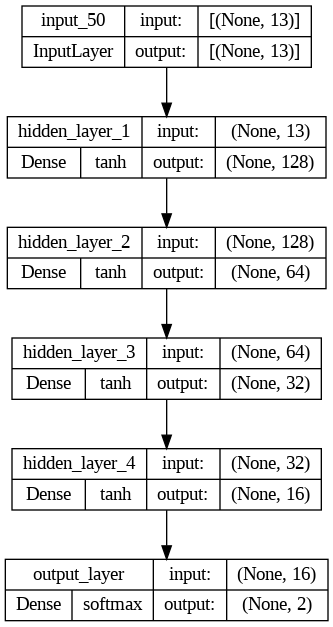

time: 60 ms (started: 2023-09-26 13:13:19 +00:00)


In [652]:
plot_model(large_model, show_shapes=True, show_layer_activations=True)

In [653]:
# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005, verbose=1)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True,
    verbose=1)

time: 1.28 ms (started: 2023-09-26 13:13:19 +00:00)


In [654]:
large_fit  = large_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[
        earlystopping,
        reduce_lr_callback
        ],
    verbose=1)
print()

Epoch 1/500
14/14 [==============================] - 1s 19ms/step - loss: 0.9114 - accuracy: 0.4792 - val_loss: 0.7454 - val_accuracy: 0.4931 - lr: 5.0000e-04
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5463 - val_loss: 0.7371 - val_accuracy: 0.4514 - lr: 5.0000e-04
Epoch 3/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6825 - accuracy: 0.5532 - val_loss: 0.7353 - val_accuracy: 0.4514 - lr: 5.0000e-04
Epoch 4/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.5532 - val_loss: 0.7373 - val_accuracy: 0.4722 - lr: 5.0000e-04
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6712 - accuracy: 0.6134 - val_loss: 0.7388 - val_accuracy: 0.3889 - lr: 5.0000e-04
Epoch 6/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6614 - accuracy: 0.6319 - val_loss: 0.7449 - val_accuracy: 0.3750 - lr: 5.0000e-04
Epoch 7/500
14/14 [==============================] 

## Assessing the Model

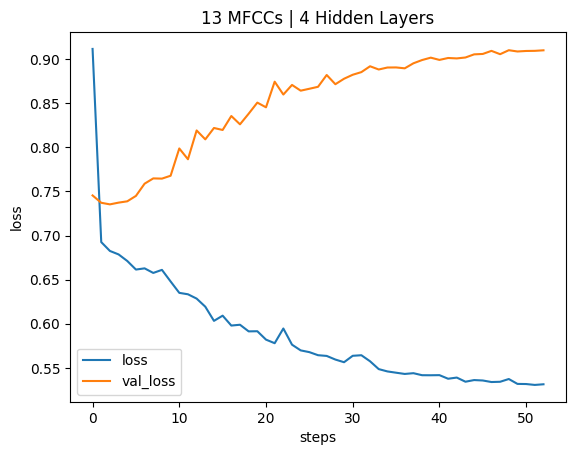

time: 544 ms (started: 2023-09-26 13:14:17 +00:00)


In [664]:
large_fit_history = pd.DataFrame(large_fit.history)
title = f'{features.shape[1]} MFCCs | {hidden_layers} Hidden Layers'
large_fit_history[['loss','val_loss']].plot(title=title,xlabel='steps', ylabel='loss')
plt.show()

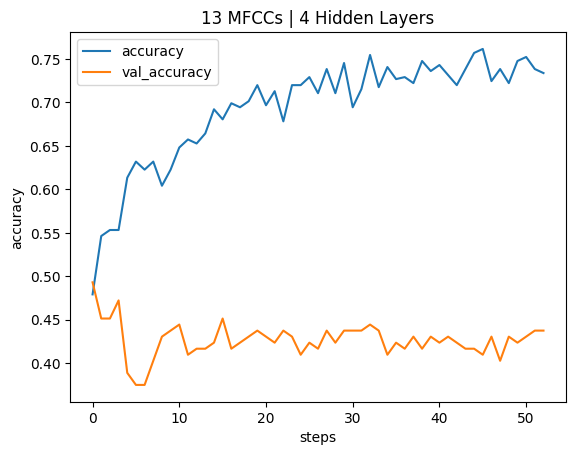

time: 264 ms (started: 2023-09-26 13:14:36 +00:00)


In [665]:
title = f'{features.shape[1]} MFCCs | {hidden_layers} Hidden Layers'
large_fit_history[['accuracy','val_accuracy']].plot(title=title,xlabel='steps', ylabel='accuracy')
plt.show()

In [657]:
large_model_accuracy = large_model.evaluate(X_test, y_test,
  verbose=0)
print(large_model_accuracy)

[0.7041136026382446, 0.5208333134651184]
time: 105 ms (started: 2023-09-26 13:13:31 +00:00)


In [679]:
large_model_y_probability = large_model.predict(X_test, verbose=0)
large_model_y_predicted = np.argmax(large_model_y_probability, axis=-1)
print(large_model_y_predicted)

[1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1]
time: 87 ms (started: 2023-09-26 13:29:56 +00:00)


In [674]:
# notice the y_test and not cat
large_model_report = metrics.classification_report(
    y_test, large_model_y_predicted, digits=4, target_names=['no-death','death'])
print(large_model_report)

              precision    recall  f1-score   support

    no-death     0.3333    0.0972    0.1505        72
       death     0.4715    0.8056    0.5949        72

    accuracy                         0.4514       144
   macro avg     0.4024    0.4514    0.3727       144
weighted avg     0.4024    0.4514    0.3727       144

time: 21.5 ms (started: 2023-09-26 13:22:34 +00:00)


In [677]:
large_model_conf_mat = metrics.confusion_matrix(y_test, large_model_y_predicted)

time: 3.2 ms (started: 2023-09-26 13:23:35 +00:00)


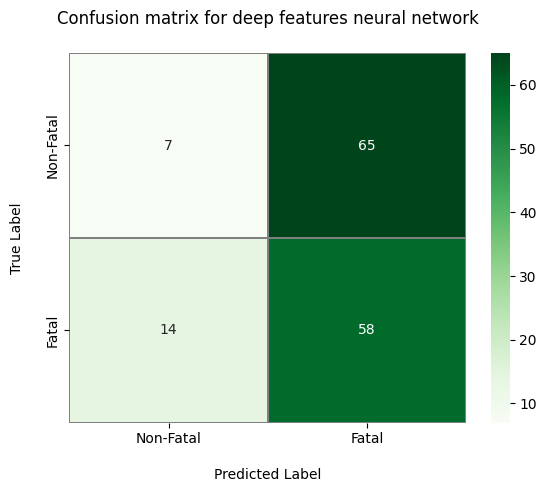

Sensitivity :  0.09722222222222222
Specificity :  0.8055555555555556
time: 244 ms (started: 2023-09-26 13:23:36 +00:00)


In [678]:
ax = sns.heatmap(
    large_model_conf_mat, annot=True, linewidths=0.01,
    cmap="Greens", linecolor="gray", fmt='g')

ax.set_xlabel("\nPredicted Label")
ax.set_ylabel("True Label\n")

ax.xaxis.set_ticklabels(['Non-Fatal','Fatal'])
ax.yaxis.set_ticklabels(['Non-Fatal','Fatal'])


ax.set_title("Confusion matrix for deep features neural network\n")

plt.show()

sensitivity1 = large_model_conf_mat[0,0]/(large_model_conf_mat[0,0]+large_model_conf_mat[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = large_model_conf_mat[1,1]/(large_model_conf_mat[1,0]+large_model_conf_mat[1,1])
print('Specificity : ', specificity1)

# MFCC Model - Small Model

## Extracting Features and Classes

### The Models' features

In [198]:
# paths
filenames = metadata_df['filename']
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=13)
features.rename('features', inplace=True)

features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

100%|██████████| 706/706 [00:31<00:00, 22.63it/s]


,filename,features
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,..."
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544..."
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ..."
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ..."
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,..."
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2...."
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195..."
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,..."
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ..."
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,..."


time: 31.2 s (started: 2023-09-26 10:53:07 +00:00)


In [199]:
print(f'Number of samples: {len(features)}')
print(f'Number of MFCCs per sample: {len(features[0])}')

Number of samples: 706
Number of MFCCs per sample: 13
time: 4.89 ms (started: 2023-09-26 10:53:38 +00:00)


 ### The Models' Classes

In [200]:
# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]

classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ...",1
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2....",1
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195...",1
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1


time: 29.4 ms (started: 2023-09-26 10:53:38 +00:00)


In [201]:
# save to csv in new data directory
features_classes_path = os.path.join(new_data_dir, 'features_classes.csv')
features_classes.to_csv(features_classes_path, encoding='utf-8', index=False)

time: 128 ms (started: 2023-09-26 10:53:38 +00:00)


### Creating Training and Testing Sets

In [470]:
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'])

time: 2.91 ms (started: 2023-09-26 12:34:25 +00:00)


In [473]:
print(classes.shape)

(706,)
time: 649 µs (started: 2023-09-26 12:34:48 +00:00)


In [481]:
print(features)

[[-4.96040649e+02  1.36326584e+02 -3.88245468e+01 ... -2.89470220e+00
  -1.10615263e+01  5.88771391e+00]
 [-5.42264832e+02  1.13492096e+02 -5.48984451e+01 ...  1.93747252e-01
  -4.04212666e+00 -1.27791238e+00]
 [-4.69104919e+02  1.44501328e+02 -5.31692390e+01 ... -6.00460529e+00
  -1.11805458e+01 -1.30216885e+01]
 ...
 [-4.30531525e+02  1.61204361e+02 -5.23065414e+01 ... -6.31104946e+00
  -9.06300354e+00 -1.20579708e+00]
 [-4.17435669e+02  1.96808456e+02 -3.47917213e+01 ...  8.26406479e+00
  -1.01011648e+01 -1.44270420e+01]
 [-4.46906708e+02  1.54580658e+02 -9.30227280e+01 ...  5.46188879e+00
  -1.95029507e+01 -8.61393738e+00]]
time: 4.24 ms (started: 2023-09-26 12:35:33 +00:00)


In [482]:
X_train, X_test, y_train, y_test = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes,
    random_state=0
    )

time: 4.32 ms (started: 2023-09-26 12:35:38 +00:00)


In [484]:
print(X_train.shape)

(529, 13)
time: 12.9 ms (started: 2023-09-26 12:35:52 +00:00)


In [476]:
print(y_train.shape)

(529,)
time: 10.9 ms (started: 2023-09-26 12:35:10 +00:00)


## Defining the Model and Training

In [631]:
input_shape = (features.shape[1],)
hidden_layers = 2
unit_scalar = 2

optimizer_name = 'Adam'
learning_rate = 0.0005
epochs = 500

model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar, optimizer_name=optimizer_name,
    learning_rate=learning_rate, epochs=epochs)

print(model.summary())

Model: "model_2hl_13mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 16)                224       
                                                                 
 hidden_layer_2 (Dense)      (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 2)                 18        
                                                                 
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
time: 102 ms (started: 2023-09-26 13:06:16 +00:00)


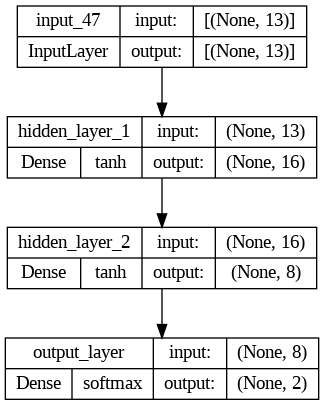

time: 64.7 ms (started: 2023-09-26 13:06:16 +00:00)


In [632]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [633]:
# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005, verbose=1)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True,
    min_delta=0.001, verbose=1)

time: 970 µs (started: 2023-09-26 13:06:16 +00:00)


In [634]:
train_res  = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[
        # checkpointer,
        earlystopping,
        reduce_lr_callback
        ],
    verbose=1
    )
print()

Epoch 1/500
14/14 [==============================] - 1s 25ms/step - loss: 0.7056 - accuracy: 0.5185 - val_loss: 0.7176 - val_accuracy: 0.4792 - lr: 5.0000e-04
Epoch 2/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6956 - accuracy: 0.5162 - val_loss: 0.7209 - val_accuracy: 0.4514 - lr: 5.0000e-04
Epoch 3/500
14/14 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5116 - val_loss: 0.7224 - val_accuracy: 0.4514 - lr: 5.0000e-04
Epoch 4/500
14/14 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5185 - val_loss: 0.7215 - val_accuracy: 0.4653 - lr: 5.0000e-04
Epoch 5/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.5208 - val_loss: 0.7239 - val_accuracy: 0.4444 - lr: 5.0000e-04
Epoch 6/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5185 - val_loss: 0.7248 - val_accuracy: 0.4514 - lr: 5.0000e-04
Epoch 7/500
14/14 [==============================] 

## Assessing the Model

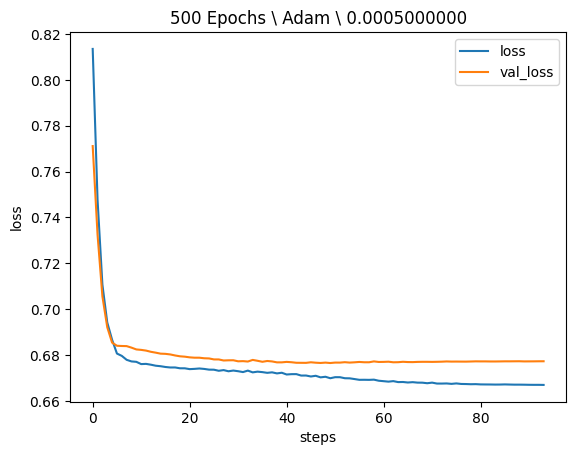

time: 278 ms (started: 2023-09-26 12:32:17 +00:00)


In [444]:
cnn_feats_history_pd = pd.DataFrame(train_res.history)
title = f'{epochs} Epochs \ {optimizer_name} \ {learning_rate:.10f}'
cnn_feats_history_pd[['loss','val_loss']].plot(title=title,xlabel='steps', ylabel='loss')
plt.show()

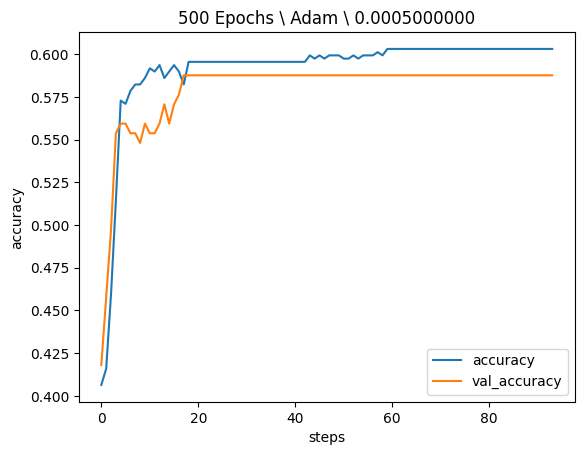

time: 295 ms (started: 2023-09-26 12:32:17 +00:00)


In [445]:
title = f'{epochs} Epochs \ {optimizer_name} \ {learning_rate:.10f}'
cnn_feats_history_pd[['accuracy','val_accuracy']].plot(title=title,xlabel='steps', ylabel='accuracy')
plt.show()

In [446]:
test_accuracy = model.evaluate(X_test, y_test,
  # batch_size=num_batch_size,
  verbose=0)
print(test_accuracy)

[0.6766244769096375, 0.5875706076622009]
time: 104 ms (started: 2023-09-26 12:32:18 +00:00)


In [447]:
y_probs = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step
time: 163 ms (started: 2023-09-26 12:32:18 +00:00)


In [448]:
y_predicted = np.argmax(y_probs, axis=-1)
print(y_predicted)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
time: 1.1 ms (started: 2023-09-26 12:32:18 +00:00)


In [449]:
# notice the y_test and not cat
print(metrics.classification_report(y_test, y_predicted, digits=4, target_names=['no-death','death']))

              precision    recall  f1-score   support

    no-death     0.4000    0.0278    0.0519        72
       death     0.5930    0.9714    0.7365       105

    accuracy                         0.5876       177
   macro avg     0.4965    0.4996    0.3942       177
weighted avg     0.5145    0.5876    0.4580       177

time: 12.8 ms (started: 2023-09-26 12:32:18 +00:00)


In [450]:
deep_feats_cm = metrics.confusion_matrix(y_test, y_predicted)

time: 2.9 ms (started: 2023-09-26 12:32:18 +00:00)


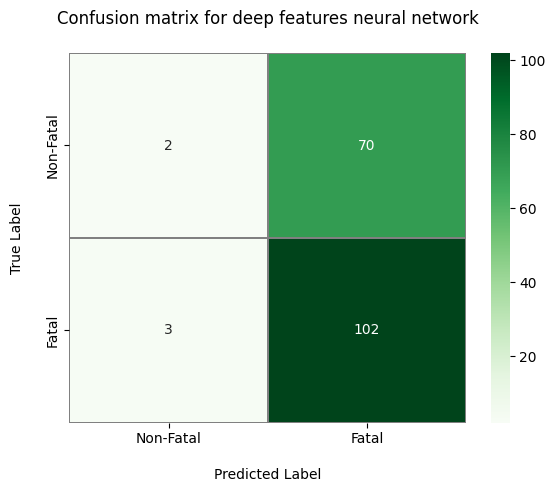

Sensitivity :  0.027777777777777776
Specificity :  0.9714285714285714
time: 277 ms (started: 2023-09-26 12:32:18 +00:00)


In [451]:
ax = sns.heatmap(deep_feats_cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='g')

ax.set_xlabel("\nPredicted Label")
ax.set_ylabel("True Label\n")

ax.xaxis.set_ticklabels(['Non-Fatal','Fatal'])
ax.yaxis.set_ticklabels(['Non-Fatal','Fatal'])


ax.set_title("Confusion matrix for deep features neural network\n")

plt.show()

sensitivity1 = deep_feats_cm[0,0]/(deep_feats_cm[0,0]+deep_feats_cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = deep_feats_cm[1,1]/(deep_feats_cm[1,0]+deep_feats_cm[1,1])
print('Specificity : ', specificity1)

# MFCC Model - Evened-out Classes

## Extracting Features and Classes

### Evening out the classes

In [410]:
print(features_classes['resulted_in_deaths'].value_counts())

1    418
0    288
Name: resulted_in_deaths, dtype: int64
time: 4.18 ms (started: 2023-09-26 12:08:04 +00:00)


In [418]:
# Create classification
num_of_non_death = features_classes['resulted_in_deaths'].value_counts()[0]
features_classes_even = features_classes.groupby('resulted_in_deaths', group_keys=False).apply(lambda x: x.sample(num_of_non_death))
features_classes_even = features_classes_even.sort_index()

features_classes_even.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1
10,911_first6sec/call_18_0.wav,"[-406.30365, 171.65135, -23.042957, -5.772533,...",0
11,911_first6sec/call_19_0.wav,"[-412.87857, 175.99988, -38.89378, -12.867564,...",0
12,911_first6sec/call_20_0.wav,"[-559.3067, 134.93155, -77.981415, 16.785315, ...",0


time: 48.9 ms (started: 2023-09-26 12:10:13 +00:00)


In [420]:
print(f'Dataframe Shape: {features_classes_even.shape}')

Dataframe Shape: (576, 3)
time: 2.35 ms (started: 2023-09-26 12:10:19 +00:00)


### Creating Trainging and Testing Sets

In [555]:
features_even = np.array(features_classes_even['features'].tolist())
classes_even = np.array(features_classes_even['resulted_in_deaths'])

time: 3.64 ms (started: 2023-09-26 12:52:19 +00:00)


In [556]:
print(classes_even.shape)

(576,)
time: 2.54 ms (started: 2023-09-26 12:52:19 +00:00)


In [557]:
print(features_even.shape)

(576, 13)
time: 698 µs (started: 2023-09-26 12:52:19 +00:00)


In [558]:
X_train, X_test, y_train, y_test = train_test_split(
    features_even, classes_even, test_size=0.25, shuffle=True,
    stratify=classes_even, random_state=0
    )

time: 6.98 ms (started: 2023-09-26 12:52:19 +00:00)


## Defining the Model and Training

In [635]:
input_shape = (features.shape[1],)
hidden_layers = 2
unit_scalar = 3

optimizer_name = 'Adam'
learning_rate = 0.0005
epochs = 500

model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar, optimizer_name=optimizer_name,
    learning_rate=learning_rate, epochs=epochs)

print(model.summary())

Model: "model_2hl_13mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                448       
                                                                 
 hidden_layer_2 (Dense)      (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 2)                 34        
                                                                 
Total params: 1010 (3.95 KB)
Trainable params: 1010 (3.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
time: 88.6 ms (started: 2023-09-26 13:06:36 +00:00)


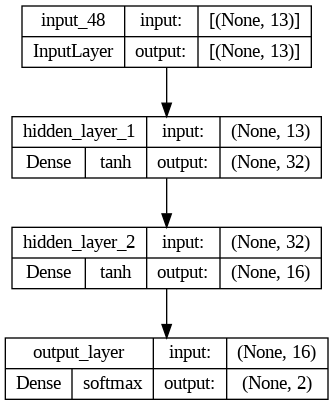

time: 49.3 ms (started: 2023-09-26 13:06:36 +00:00)


In [636]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [637]:
# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005, verbose=1)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True,
    min_delta=0.001, verbose=1)

time: 994 µs (started: 2023-09-26 13:06:36 +00:00)


In [638]:
train_res  = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[
        # checkpointer,
        earlystopping,
        reduce_lr_callback
        ],
    verbose=1
    )
print()

Epoch 1/500
14/14 [==============================] - 1s 22ms/step - loss: 0.7384 - accuracy: 0.4676 - val_loss: 0.7054 - val_accuracy: 0.5417 - lr: 5.0000e-04
Epoch 2/500
14/14 [==============================] - 0s 6ms/step - loss: 0.7159 - accuracy: 0.4745 - val_loss: 0.7076 - val_accuracy: 0.5278 - lr: 5.0000e-04
Epoch 3/500
14/14 [==============================] - 0s 7ms/step - loss: 0.7076 - accuracy: 0.4838 - val_loss: 0.7087 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 4/500
14/14 [==============================] - 0s 10ms/step - loss: 0.7018 - accuracy: 0.4931 - val_loss: 0.7070 - val_accuracy: 0.5347 - lr: 5.0000e-04
Epoch 5/500
14/14 [==============================] - 0s 11ms/step - loss: 0.7015 - accuracy: 0.4954 - val_loss: 0.7051 - val_accuracy: 0.5347 - lr: 5.0000e-04
Epoch 6/500
14/14 [==============================] - 0s 10ms/step - loss: 0.6965 - accuracy: 0.5093 - val_loss: 0.7054 - val_accuracy: 0.5347 - lr: 5.0000e-04
Epoch 7/500
14/14 [=============================

## Assessing the Model

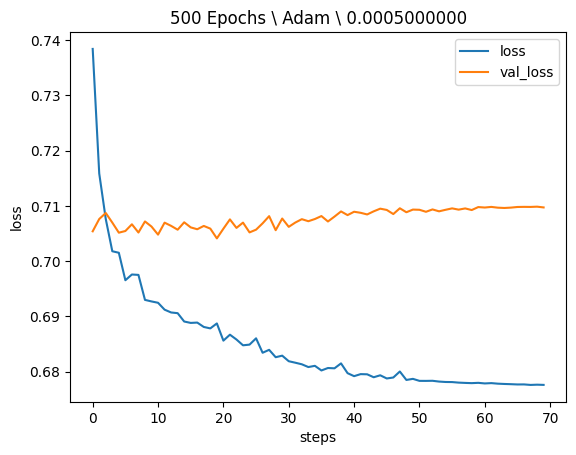

time: 320 ms (started: 2023-09-26 13:06:46 +00:00)


In [639]:
cnn_feats_history_pd = pd.DataFrame(train_res.history)
title = f'{epochs} Epochs \ {optimizer_name} \ {learning_rate:.10f}'
cnn_feats_history_pd[['loss','val_loss']].plot(title=title,xlabel='steps', ylabel='loss')
plt.show()

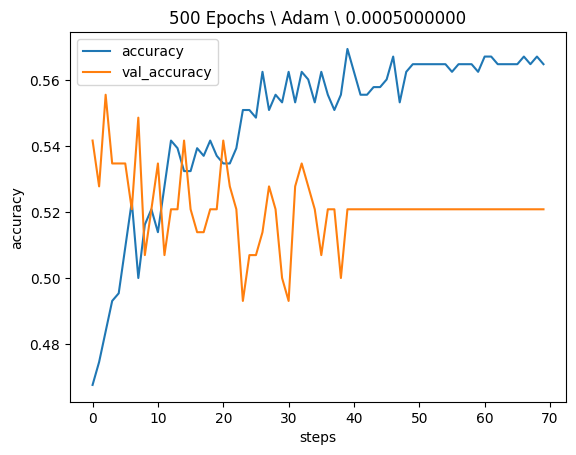

time: 335 ms (started: 2023-09-26 13:06:46 +00:00)


In [640]:
title = f'{epochs} Epochs \ {optimizer_name} \ {learning_rate:.10f}'
cnn_feats_history_pd[['accuracy','val_accuracy']].plot(title=title,xlabel='steps', ylabel='accuracy')
plt.show()

In [641]:
test_accuracy = model.evaluate(X_test, y_test,
  # batch_size=num_batch_size,
  verbose=0)
print(test_accuracy)

[0.7041136026382446, 0.5208333134651184]
time: 95.5 ms (started: 2023-09-26 13:06:47 +00:00)


In [642]:
y_probs = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step
time: 166 ms (started: 2023-09-26 13:06:47 +00:00)


In [643]:
y_predicted = np.argmax(y_probs, axis=-1)
print(y_predicted)

[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0
 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0
 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1
 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
time: 3.53 ms (started: 2023-09-26 13:06:47 +00:00)


In [644]:
# notice the y_test and not cat
print(metrics.classification_report(y_test, y_predicted, digits=4, target_names=['no-death','death']))

              precision    recall  f1-score   support

    no-death     0.5158    0.6806    0.5868        72
       death     0.5306    0.3611    0.4298        72

    accuracy                         0.5208       144
   macro avg     0.5232    0.5208    0.5083       144
weighted avg     0.5232    0.5208    0.5083       144

time: 14.6 ms (started: 2023-09-26 13:06:47 +00:00)


In [645]:
deep_feats_cm = metrics.confusion_matrix(y_test, y_predicted)

time: 2.3 ms (started: 2023-09-26 13:06:47 +00:00)


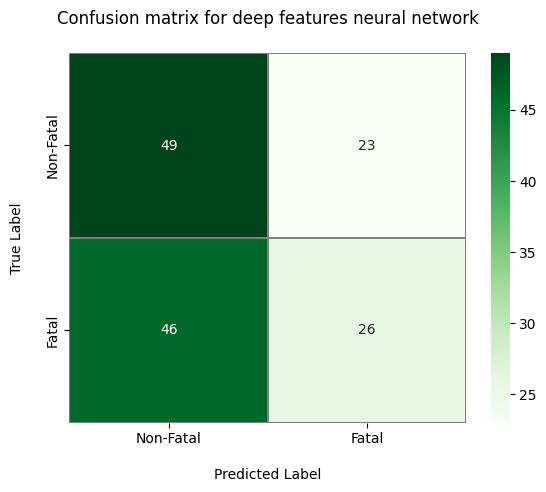

Sensitivity :  0.6805555555555556
Specificity :  0.3611111111111111
time: 279 ms (started: 2023-09-26 13:06:47 +00:00)


In [646]:
ax = sns.heatmap(deep_feats_cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='g')

ax.set_xlabel("\nPredicted Label")
ax.set_ylabel("True Label\n")

ax.xaxis.set_ticklabels(['Non-Fatal','Fatal'])
ax.yaxis.set_ticklabels(['Non-Fatal','Fatal'])


ax.set_title("Confusion matrix for deep features neural network\n")

plt.show()

sensitivity1 = deep_feats_cm[0,0]/(deep_feats_cm[0,0]+deep_feats_cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = deep_feats_cm[1,1]/(deep_feats_cm[1,0]+deep_feats_cm[1,1])
print('Specificity : ', specificity1)